In [1]:
import numpy as np
import awkward as ak
from fast_histogram import histogram2d
import matplotlib.pyplot as plt
import argparse
import logging
from datetime import datetime
import sys
from pathlib import Path
import pickle 

#set global variables
MAX_EVENTS = 10000

data_path = f"/disk/atlas3/data_MC/delphes/BH_n4_M10_10000events.root:Delphes" 

#Set resolution
MIN_RES = 20
RESOLUTION = 50


In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from imcal import *
from imcal import Hdf5Dataset

In [3]:

#Load data
clusters = load_data(data_path, MAX_EVENTS, "Tower", 
                        ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"])
tracks = load_data(data_path, MAX_EVENTS, "Track", 
                        ["Track.PT", "Track.Eta", "Track.Phi"])

eventid = load_data(data_path, MAX_EVENTS, "Event", ["Event.Number"])

print(f"Number of events loaded: {len(clusters)}")


Loading 10000 events from branch Tower, fields ['Tower.ET', 'Tower.Eta', 'Tower.Phi', 'Tower.Eem', 'Tower.Ehad'].
Loading 10000 events from branch Track, fields ['Track.PT', 'Track.Eta', 'Track.Phi'].
Loading 10000 events from branch Event, fields ['Event.Number'].
Number of events loaded: 10000


In [4]:
print(tracks.PT)

[[267, 0.831, 34.7, 78.2, 2.1, 0.613, ... 0.489, 1.32, 2.5, 1.62, 0.784, 48.9]]


In [5]:
edge_tracks = tracks[abs(tracks["Eta"])>2.6]

values = {"PT":[], "Eta":[], "Phi":[], "EventNumber":[]}
for i, hit in enumerate(edge_tracks):
    hit = ak.to_list(hit)
    if len(hit) > 0:
        values["PT"].append(hit[0]["PT"])
        values["Eta"].append(hit[0]["Eta"])
        values["Phi"].append(hit[0]["Phi"])
        values["EventNumber"].append(i)

df = pd.DataFrame(values)
print(df)

         PT       Eta       Phi  EventNumber
0  0.119908 -2.840896 -0.441638          537
1  0.492408 -2.643695  0.391767         2493
2  0.559976  2.659502  0.285224         3221
3  0.775235  2.639060  0.692546         4776
4  0.291009  2.679379 -2.219066         5244
5  0.161058 -2.771201  0.279189         8063
6  0.507858 -2.648678 -1.490665         8580


In [6]:
#Pad Tower data
max_hits = np.max([len(event) for event in clusters["Eta"]])
print(f"Padding towers to size: {max_hits}")
clusters = ak.pad_none(clusters, max_hits, axis=-1)

#Pad track data
max_hits = np.max([len(event) for event in tracks["Eta"]])
print(f"Padding tracks to size: {max_hits}")
tracks = ak.pad_none(tracks, max_hits, axis=-1)


Padding towers to size: 529
Padding tracks to size: 418


In [7]:
test = ak.to_numpy(clusters.Phi)
test.fill_value = None

In [8]:
print((np.ma.getdata(test[0][-1])))
print(type(test))

0.0
<class 'numpy.ma.core.MaskedArray'>


In [9]:

# Creating the histograms
hists_Eem = create_histograms(ak.to_numpy(clusters.Phi), ak.to_numpy(clusters.Eta), 
                                ak.to_numpy(clusters.Eem), MAX_EVENTS, RESOLUTION)
hists_Ehad = create_histograms(ak.to_numpy(clusters.Phi), ak.to_numpy(clusters.Eta), 
                                ak.to_numpy(clusters.Ehad), MAX_EVENTS, RESOLUTION)
hists_tracks = create_histograms(ak.to_numpy(tracks.Phi), ak.to_numpy(tracks.Eta), 
                                    ak.to_numpy(tracks.PT), MAX_EVENTS, RESOLUTION)

In [10]:

#Stack to 3 channel
images = np.stack((hists_Eem, hists_Ehad, hists_tracks), axis=-1)
print(f"Image data shape: {images.shape}")


Image data shape: (10000, 50, 50, 3)


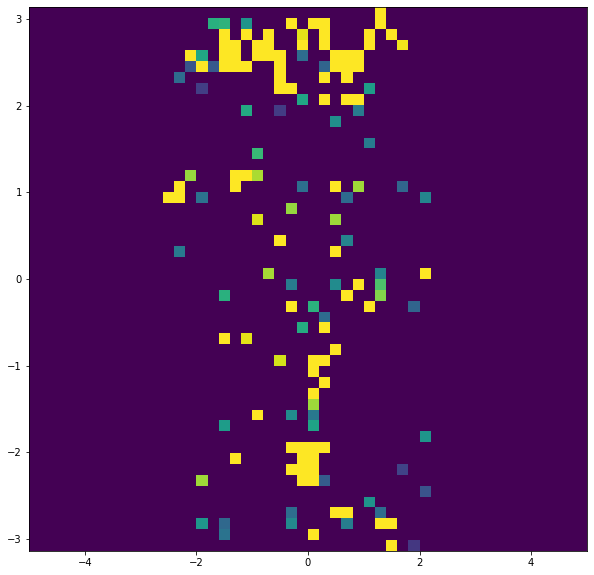

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(images[9620][:,:,2], vmin=0, vmax=1, extent=[-5, 5, -np.pi, np.pi], aspect='auto')